In [95]:
import re
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [5]:
newsgroups = fetch_20newsgroups('dataset/news_data')
target = newsgroups['target_names'][newsgroups['target'][0]]


In [41]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'


In [8]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' else -1 for target in newsgroups['target']]

train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=17)


# Классификация писем на тематики "автомобильная" и "не автомобильные"

In [33]:
with open('dataset/news_data/20news_train.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))

with open('dataset/news_data/20news_test.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))
        

Обучаем модель

In [34]:
!vw -d dataset/news_data/20news_train.vw \
  --loss_function hinge -f dataset/news_data/20news_model.vw

final_regressor = dataset/news_data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = dataset/news_data/20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      144
0.500000 0.000000            2            2.0  -1.0000  -1.0000      270
0.340324 0.180648            4            4.0  -1.0000  -0.9480      244
0.417071 0.493818            8            8.0  -1.0000  -1.0000      151
0.283219 0.149366           16           16.0  -1.0000  -1.0000      128
0.211971 0.140724           32           32.0  -1.0000  -0.3997       28
0.116923 0.021875           64           64.0  -1.0000  -1.0000      103
0.158355 0.199787          128          128.0  -1.0000  -0.8313      127
0.125210 0.092065          256          256.0  -1.0000  -0.9422  

Предсказываем и записываем в файл

In [35]:
!vw -i dataset/news_data/20news_model.vw -t -d dataset/news_data/20news_test.vw \
-p dataset/news_data/20news_test_predictions.txt


only testing
predictions = dataset/news_data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = dataset/news_data/20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown  -1.0000      143
    n.a.     n.a.            2            2.0  unknown  -1.0000       42
    n.a.     n.a.            4            4.0  unknown  -0.8455       72
    n.a.     n.a.            8            8.0  unknown   0.5062       54
    n.a.     n.a.           16           16.0  unknown  -1.0000      796
    n.a.     n.a.           32           32.0  unknown  -1.0000      187
    n.a.     n.a.           64           64.0  unknown  -0.5900      215
    n.a.     n.a.          128          128.0  unknown  -1.0000      139
    n.a.     n.a.          256          256.0

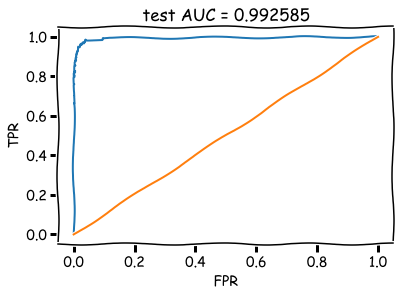

In [40]:
with open('dataset/news_data/20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); 
    plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);

# Многоклассовая классификация

In [80]:
all_documents = newsgroups['data']
all_targets_mult = newsgroups['target'] + 1

In [82]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=17)

with open('dataset/news_data/20news_train_mult.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
        
with open('dataset/news_data/20news_test_mult.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Обучаем модель.
-oaa - one-against-all

In [85]:
%%time
!vw --oaa 20 dataset/news_data/20news_train_mult.vw \
-f dataset/news_data/20news_model_mult.vw --loss_function=hinge

Wall time: 1.14 s


final_regressor = dataset/news_data/20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = dataset/news_data/20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1      144
0.500000 1.000000            2            2.0       16        1      270
0.750000 1.000000            4            4.0       10       14      244
0.875000 1.000000            8            8.0       13       10      151
0.937500 1.000000           16           16.0        9       17      128
0.875000 0.812500           32           32.0       15        5       28
0.875000 0.875000           64           64.0        3        3      103
0.835938 0.796875          128          128.0       15       15      127
0.750000 0.664063          256          256.0       20 

In [88]:
%%time
!vw -i dataset/news_data/20news_model_mult.vw -t \
-d dataset/news_data/20news_test_mult.vw \
-p dataset/news_data/20news_test_predictions_mult.txt

Wall time: 192 ms


only testing
predictions = dataset/news_data/20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = dataset/news_data/20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        4      143
    n.a.     n.a.            2            2.0  unknown        5       42
    n.a.     n.a.            4            4.0  unknown       13       72
    n.a.     n.a.            8            8.0  unknown        8       54
    n.a.     n.a.           16           16.0  unknown        1      796
    n.a.     n.a.           32           32.0  unknown       11      187
    n.a.     n.a.           64           64.0  unknown       13      215
    n.a.     n.a.          128          128.0  unknown       13      139
    n.a.     n.a.          256     

In [89]:
with open('dataset/news_data/20news_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [91]:
accuracy_score(test_labels_mult, test_prediction_mult)


0.871332626369742

#### C какими темами классификатор путает атеизм

In [102]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0, i])


comp.sys.ibm.pc.hardware 1
rec.sport.hockey 1
soc.religion.christian 3
talk.politics.guns 2
talk.religion.misc 8
